# X3D (eXpanded 3D) Implementation - Design Alternative 1

`Warning:` Do not run all the code, read the notes first before running them as they may reduce your device's memory when not careful, leading to a kernel crash or Out-Of-Memory (OOM) Error, sige ka magla-lag yang pc mo

**Local System Specifications used to train the model:** <br>
| Component  | Device   |
| :------------- | :--------------- | 
| CPU   | AMD Ryzen 5 5600x     | 
| GPU   | Nvidia GeForce RTX 3070  8GB   | 
| RAM   | 32 GB     | 


## Create the dataset

#### Import Libraries and Configure Device

In [1]:
## Uncomment if you are running on colab

#!pip install keras-tuner imageio opencv-python tqdm seaborn scikit-learn
#!pip install -q git+https://github.com/tensorflow/docs

#!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
#!unrar x UCF101.rar

In [2]:
from tqdm import tqdm
import random
import pathlib
import itertools
import collections 
import os

import imageio
import shutil
import cv2
import mediapipe as mp
import einops
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow_docs.vis import embed
import tensorflow as tf
import keras
import keras_tuner as kt
from keras import layers

2024-11-29 10:25:30.270638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732847132.099019    1198 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732847132.537494    1198 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 10:25:36.764954: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
## Limit usage of VRAM to prevent OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_virtual_device_configuration(gpu,
                                                             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5820)])

`Note`: Ikaw bahala sa pag lagay ng memory limit, check your gpu specs and refer to that specs when changing.

#### Visualize the data first

In [4]:
def visulize_data(fil_dir):
    """ 
    Let's you visualize the video

    Args:
        fil_dir: Directory of files

    Returns:
        Plot of videos along with the labels

    """

    plt.figure(figsize=(20, 20))
    all_class_names = os.listdir(path=fil_dir)
    random_range = random.sample(range(len(all_class_names)),
                                  len(all_class_names)-random.randrange(1, len(all_class_names)))

    for counter, rand_idx in enumerate(random_range, 1):
        selected_class_name = all_class_names[rand_idx]
        video_files_names_list = os.listdir(f'{fil_dir}/{selected_class_name}')
        selected_video_file_name = random.choice(video_files_names_list)

        video_reader = cv2.VideoCapture(f'{fil_dir}/{selected_class_name}/{selected_video_file_name}')
        _, frame = video_reader.read()
        video_reader.release()

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        cv2.putText(rgb_frame, selected_class_name, (10,30), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,255), 2)

        plt.subplot(5, 4, counter)
        plt.imshow(rgb_frame)
        plt.axis('off')

#### Loading of dataset

In [5]:
## Define the dimensions of frames in the set of frames created (Default params muna)
HEIGHT = 224
WIDTH = 224
SEQUENCE_LENGTH = 20 # small frame raw para small memory at computation ang gawin, ndi kakakayanin ng mga nasa 16GB lang
LABELS = sorted(['BarbellCurl', 'Deadlift', 'Squat', 'LateralRaises', 'OverheadPress'
          ]) # Eto muna

- `Note`: This can be changed later on once model is okay

In [6]:
def split_dataset(dataset_dir, 
                  splits={"train": 0.7, "val": 0.15, "test": 0.15}, 
                  seed=42, 
                  selected_classes=None):
    """
    Split the video dataset into train, validation, and test sets and save to subdirectories.
    Ensures no data duplication across splits.
    """
    random.seed(seed)
    
    # Convert dataset directory to Path object
    dataset_dir = pathlib.Path(dataset_dir)
    splits_dirs = ["train", "val", "test"]

    # Remove existing split directories to avoid data overlap
    for split in splits_dirs:
        split_dir = dataset_dir / split
        if split_dir.exists():
            shutil.rmtree(split_dir)

    # Iterate over each class folder in the dataset
    class_dirs = [f for f in dataset_dir.iterdir() if f.is_dir()]
    
    # Filter classes if `selected_classes` is provided
    if selected_classes:
        class_dirs = [f for f in class_dirs if f.name in selected_classes]
    
    for class_dir in tqdm(class_dirs, desc="Processing classes", unit="class"): # May loading yan :)
        print(f"\nProcessing class: {class_dir.name}")
        
        # Get a list of video files in the class directory
        video_files = [f for f in class_dir.iterdir() if f.is_file()]
        
        random.shuffle(video_files)
        
        num_videos = len(video_files)
        train_end = int(splits["train"] * num_videos)
        val_end = train_end + int(splits["val"] * num_videos)
        
        # Split the video files into train, val, and test 
        train_files = video_files[:train_end]
        val_files = video_files[train_end:val_end]
        test_files = video_files[val_end:]
        
        # Move files to directories (tran, val, test)
        for split, files in zip(splits_dirs, [train_files, val_files, test_files]):
            split_dir = dataset_dir / split / class_dir.name
            split_dir.mkdir(parents=True, exist_ok=True)  # Create the class folder in the split directory
            
            for file in tqdm(files, desc=f"Moving files to {split}/{class_dir.name}", unit="file"):
                shutil.move(str(file), str(split_dir / file.name))
    
    print("\nDataset split complete!")

In [7]:
## File path
file_path = './Workout/' 

In [ ]:
## Split the dataset, if na-run na ng isang beses wag na i-run ule, dahil sa code na hindi pa naayos, mawawala lahat yan since na split na si dataset
#split_dataset(file_path, splits={"train": 0.7, "val": 0.15, "test": 0.15}, selected_classes=LABELS) 

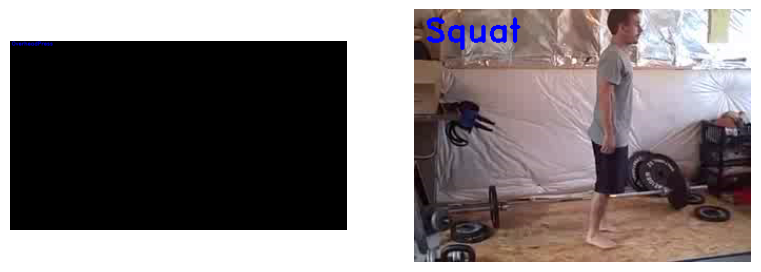

In [9]:
visulize_data(file_path + 'train/')

In [10]:
## Creates a path to the dataset
dataset_paths = {'train':pathlib.PosixPath(f'{file_path}train'),
                    'val':pathlib.PosixPath(f'{file_path}val'),
                    'test':pathlib.PosixPath(f'{file_path}test')}

#### Create Frames from each video

In [11]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [12]:
def frames_from_video_file(video_path, n_frames, output_size=(224, 224)):
    result = []
    src = cv2.VideoCapture(str(video_path))
    video_length = int(src.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_step = max(1, video_length // n_frames)

    if video_length <= n_frames:
        start = 0
    else:
        max_start = video_length - n_frames * frame_step
        start = random.randint(0, max_start)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    ret, frame = src.read()
    if ret:
        result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            result.append(format_frames(frame, output_size))
        else:
            result.append(np.zeros_like(result[0]))

    src.release()
    result = np.array(result)[..., [2, 1, 0]]
    return result

In [13]:
def augment_frames(frames):
    augmented_frames = []
    for frame in frames:
        frame = tf.image.random_flip_left_right(frame)
        frame = tf.image.random_brightness(frame, max_delta=0.2)
        frame = tf.image.random_contrast(frame, lower=0.8, upper=1.2)
        frame = tf.image.random_saturation(frame, lower=0.8, upper=1.2)
        augmented_frames.append(frame)
    return tf.stack(augmented_frames)

In [14]:
class FrameGenerator:
    def __init__(self, path, n_frames, training=False, augment=False):
        self.path = path
        self.n_frames = n_frames
        self.training = training
        self.augment = augment
        self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
        self.class_ids_for_name = {name: idx for idx, name in enumerate(self.class_names)}

    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*/*.avi')) + list(self.path.glob('*/*.mov')) + list(self.path.glob('*/*.mp4'))
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()
        pairs = list(zip(video_paths, classes))
        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = frames_from_video_file(path, self.n_frames, output_size=(HEIGHT, WIDTH))
            if self.augment and self.training:
                video_frames = augment_frames(video_frames)
            label = self.class_ids_for_name[name]
            yield video_frames, label

In [15]:
## Pinagsama na yung framgen at output signature 
def configure_dataset(dataset_path, n_frames, batch_size=2, training=False, augment=False):
    frame_gen = FrameGenerator(dataset_path, n_frames, training=training, augment=augment)
    output_signature = (
        tf.TensorSpec(shape=(SEQUENCE_LENGTH, HEIGHT, WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int16)
    )
    ds = tf.data.Dataset.from_generator(frame_gen, output_signature=output_signature)
    if training:
        ds = ds.cache().shuffle(1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    else:
        ds = ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

#### Split and Generate the datasets

In [16]:
train_ds = configure_dataset(dataset_paths['train'], SEQUENCE_LENGTH, training=True, augment=True)

# Create the training set
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

I0000 00:00:1732847217.248405    1198 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5820 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:07:00.0, compute capability: 8.6
2024-11-29 10:27:08.286682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 5 of 1000
2024-11-29 10:27:30.566832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 32 of 1000
2024-11-29 10:27:47.945559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 76 of 1000
2024-11-29 10:27:59.561039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 104 of 1000
2024-11-29 10:28:19.302955: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle

Shape of training set of frames: (2, 20, 224, 224, 3)
Shape of training labels: (2,)


2024-11-29 10:29:40.415258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


In [17]:
val_ds = configure_dataset(dataset_paths['val'], SEQUENCE_LENGTH, training=False)

# Create the training set
val_frames, val_labels = next(iter(val_ds))
print(f'Shape of training set of frames: {val_frames.shape}')
print(f'Shape of training labels: {val_labels.shape}')

Shape of training set of frames: (2, 20, 224, 224, 3)
Shape of training labels: (2,)


- `Note`: Datasets can be configured to increase performance when loading and training it in a model, this is called *prefetch*. The *prefetch* is efficient when loading the dataset in the memory, making it faster; it also helps with utilizing the GPU, making it train faster.

#### Plotting Functions for later

In [18]:
def plot_history(history):
    """
        Plotting training and validation learning curves.
        Args: 
         history: model history with all the metric measures
    """
    fig, (ax1, ax2) = plt.subplots(2)

    fig.set_size_inches(18.5, 10.5)

    # Plot loss
    ax1.set_title('Loss')
    ax1.plot(history.history['loss'], label = 'train')
    ax1.plot(history.history['val_loss'], label = 'test')
    ax1.set_ylabel('Loss')

    # Determine upper bound of y-axis
    max_loss = max(history.history['loss'] + history.history['val_loss'])

    ax1.set_ylim([0, np.ceil(max_loss)])
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'])

    # Plot accuracy
    ax2.set_title('Accuracy')
    ax2.plot(history.history['accuracy'],  label = 'train')
    ax2.plot(history.history['val_accuracy'], label = 'test')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim([0, 1])
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'])

    plt.show()

In [19]:
def get_actual_predicted_labels(dataset, trained_model):
    """
        Create a list of actual ground truth values and the predictions from the model.

        Args:
        dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

        Return:
        Ground truth and predicted values for a particular dataset.
    """
    actual = [labels for _, labels in dataset.unbatch()]
    predicted = trained_model.predict(dataset)

    actual = tf.stack(actual, axis=0)
    predicted = tf.concat(predicted, axis=0)
    predicted = tf.argmax(predicted, axis=1)

    return actual, predicted


def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt='g')
    sns.set(rc={'figure.figsize':(12, 12)})
    sns.set(font_scale=1.4)
    ax.set_title('Confusion matrix of action recognition for ' + ds_type)
    ax.set_xlabel('Predicted Action')
    ax.set_ylabel('Actual Action')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

In [20]:
def calculate_classification_metrics(y_actual, y_pred, labels):
    """
      Calculate the precision and recall of a classification model using the ground truth and
      predicted values.

      Args:
        y_actual: Ground truth labels.
        y_pred: Predicted labels.
        labels: List of classification labels.

      Return:
        Precision and recall measures.
    """
    cm = tf.math.confusion_matrix(y_actual, y_pred)
    tp = np.diag(cm) # Diagonal represents true positives
    precision = dict()
    recall = dict()
    for i in range(len(labels)):
      col = cm[:, i]
      fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

      row = cm[i, :]
      fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

      precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision

      recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

    return precision, recall

In [21]:
def calculate_f1_score(y_actual, y_pred, labels, average='macro'):
    """
    Calculate F1-Score for each class and optionally a macro-average.

    Args:
        y_actual: Ground truth labels.
        y_pred: Predicted labels.
        labels: List of classification labels.
        average: 'macro' to return average F1-score, 'none' to return per-class F1-score.

    Returns:
        A dictionary of F1-Scores per class and/or the macro-average F1-Score.
    """
    cm = tf.math.confusion_matrix(y_actual, y_pred)
    tp = np.diag(cm)  # True positives (diagonal of confusion matrix)
    precision = tp / (np.sum(cm, axis=0) + 1e-7)  # Avoid division by zero
    recall = tp / (np.sum(cm, axis=1) + 1e-7)

    f1_scores = {label: 2 * (precision[i] * recall[i]) / (precision[i] + recall[i] + 1e-7)
                 for i, label in enumerate(labels)}

    if average == 'macro':
        macro_f1 = np.mean(list(f1_scores.values()))
        return f1_scores, macro_f1

    return f1_scores

In [22]:
from sklearn.metrics import average_precision_score

def calculate_map(y_actual, y_pred, num_classes):
    """
    Calculate the Mean Average Precision (mAP) for multi-class classification.

    Args:
        y_actual: Ground truth labels (class indices).
        y_pred: Predicted probabilities (e.g., softmax outputs from the model).
        num_classes: The number of classes in the dataset.

    Returns:
        map_score: The Mean Average Precision score.
    """
    # Convert the actual labels to one-hot encoding for mAP calculation
    y_actual_one_hot = np.eye(num_classes)[y_actual]
    
    aps = []
    for i in range(num_classes):
        # Average precision for each class (using one-vs-rest strategy)
        ap = average_precision_score(y_actual_one_hot[:, i], y_pred[:, i])
        aps.append(ap)

    map_score = np.mean(aps)
    return map_score


In [23]:
from sklearn.metrics import precision_recall_curve, auc

def plot_precision_recall_curve(y_actual, y_pred, labels):
    """
    Plot Precision-Recall curve and calculate AUC for each class.

    Args:
        y_actual: Ground truth labels (class indices).
        y_pred: Predicted probabilities (e.g., softmax outputs from the model).
        labels: List of class names.

    Returns:
        auc_scores: Dictionary of AUC-PR for each class.
    """
    auc_scores = {}
    plt.figure(figsize=(10, 8))

    for i, label in enumerate(labels):
        # Calculate Precision and Recall values for each class
        precision, recall, _ = precision_recall_curve(y_actual == i, y_pred[:, i])
        pr_auc = auc(recall, precision)
        auc_scores[label] = pr_auc

        # Plot the precision-recall curve for each class
        plt.plot(recall, precision, label=f'{label} (AUC = {pr_auc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    return auc_scores


## Model Structuring, HyperTuning, and Training

This Network Architecture is from the paper [X3D: Expanding Architectures for Efficient Video Recognition](https://arxiv.org/abs/2004.04730)

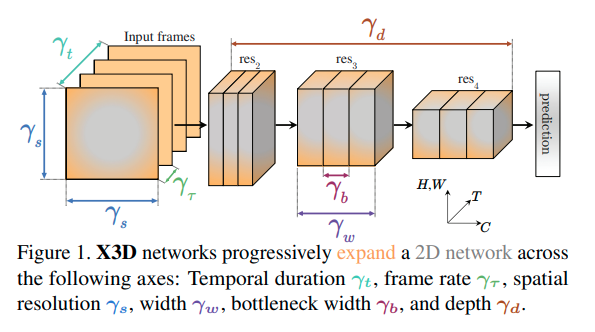

- `Note`: The structure of the is based on the figure above, it will be modified to tailor our project design's specific objectives

#### Network Building and HyperTuning of Parameters

In [24]:
@keras.saving.register_keras_serializable()
class SEBlock(keras.layers.Layer):
    def __init__(self, filters, reduction=16, **kwargs):
        super(SEBlock, self).__init__(**kwargs)
        self.global_avg_pool = layers.GlobalAveragePooling3D()
        self.fc1 = layers.Dense(filters // reduction, activation='relu')
        self.fc2 = layers.Dense(filters, activation='sigmoid')
        self.reshape = layers.Reshape((1, 1, 1, filters))

    def call(self, inputs):
        se = self.global_avg_pool(inputs)
        se = self.fc1(se)
        se = self.fc2(se)
        se = self.reshape(se)
        return inputs * se

@keras.saving.register_keras_serializable()
class X3DBottleneck(keras.layers.Layer):
    def __init__(self, filters, strides=(1, 1, 1), **kwargs):
        super(X3DBottleneck, self).__init__(**kwargs)
        self.filters = filters
        self.strides = strides

        # Define the layers inside the bottleneck block
        self.conv1 = layers.Conv3D(filters, kernel_size=(1, 1, 1), strides=(1, 1, 1), padding="same")
        self.bn1 = layers.BatchNormalization()
        self.relu1 = layers.ReLU()

        self.conv2 = layers.Conv3D(filters, kernel_size=(3, 3, 3), strides=strides, padding="same")
        self.bn2 = layers.BatchNormalization()
        self.relu2 = layers.ReLU()

        self.conv3 = layers.Conv3D(filters, kernel_size=(1, 1, 1), strides=(1, 1, 1), padding="same")
        self.bn3 = layers.BatchNormalization()

        # Shortcut layer for residual connection
        self.shortcut = layers.Conv3D(filters, kernel_size=(1, 1, 1), strides=strides, padding="same")
        self.shortcut_bn = layers.BatchNormalization()

        self.add = layers.Add()
        self.relu_out = layers.ReLU()

    def call(self, inputs, training=False):
        # Main path
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.bn3(x, training=training)

        # Shortcut path
        shortcut = self.shortcut(inputs)
        shortcut = self.shortcut_bn(shortcut, training=training)

        # Add main and shortcut paths
        x = self.add([x, shortcut])
        x = self.relu_out(x)

        return x

In [25]:
class X3D(kt.HyperModel):
    def __init__(self, num_classes, sequence_length, shape):
        self.num_classes = num_classes
        self.input_shape = (None, sequence_length, shape[0], shape[1], 3)

    def build(self, hp):
        inputs = layers.Input(shape=self.input_shape[1:])
        x = inputs

        # Base Conv Layer
        base_filters = hp.Choice('base_filters', values=[16, 24, 32])
        x = layers.Conv3D(
            base_filters, kernel_size=(5, 7, 7), strides=(1, 2, 2), padding='same', kernel_initializer='he_normal'
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.MaxPooling3D(pool_size=(1, 3, 3), strides=(1, 2, 2), padding='same')(x)

        # Stacked Bottleneck Blocks
        filters = base_filters
        for stage in range(4):  # 4 stages
            num_blocks = hp.Int(f'num_blocks_stage{stage + 1}', min_value=1, max_value=3, step=1)
            for block in range(num_blocks):
                strides = (1, 2, 2) if block == 0 and stage > 0 else (1, 1, 1)
                x = X3DBottleneck(filters, strides=strides)(x)

                # Add SEBlock conditionally
                if hp.Boolean('use_seblock'):
                    x = SEBlock(filters)(x)

            filters *= 2  # Double filters after each stage

        # Global Head
        x = layers.GlobalAveragePooling3D()(x)
        dense_units = hp.Int('dense_units', min_value=128, max_value=512, step=128)
        x = layers.Dense(dense_units, activation='relu', kernel_initializer='he_normal')(x)
        dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.4, step=0.05)
        x = layers.Dropout(dropout_rate)(x)
        outputs = layers.Dense(self.num_classes)(x)  # Logits output

        # Compile the model
        lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')
        optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
        if optimizer_choice == 'adam':
            optimizer = keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)
        else:
            optimizer = keras.optimizers.RMSprop(learning_rate=lr, rho=0.9, epsilon=1e-7, centered=False)

        model = keras.Model(inputs, outputs)
        model.compile(
            optimizer=optimizer,
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )

        return model

In [26]:
## Tuner initislization
tuner = kt.BayesianOptimization(
    hypermodel=X3D(len(LABELS), SEQUENCE_LENGTH, (HEIGHT, WIDTH)),
    objective='val_accuracy',
    max_trials=5,  # Number of hyperparameter configurations to try, 5 muna kasi malakas makaubos ng oras
    executions_per_trial=2,  # Average over multiple runs
    directory='X3D',
    project_name='model_tuning'
)

In [27]:
tuner.search(train_ds, validation_data=val_ds, epochs=10)

Trial 5 Complete [00h 08m 34s]
val_accuracy: 0.6000000238418579

Best val_accuracy So Far: 0.6000000238418579
Total elapsed time: 00h 43m 46s


In [28]:
hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]
model_1 = tuner.hypermodel.build(hyperparams)

In [29]:
frames, label = next(iter(train_ds))
model_1.build(frames)
model_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 20, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_21 (Conv3D)              │ (None, 20, 112, 112,   │        17,664 │
│                                 │ 24)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 20, 112, 112,   │            96 │
│ (BatchNormalization)            │ 24)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 20, 112, 112,   │             0 │
│                                 │ 24)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 20, 56, 56, 24) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x3d_bottleneck_5                │ (None, 20, 56, 56, 24) │        17,760 │
│ (X3DBottleneck)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x3d_bottleneck_6                │ (None, 20, 56, 56, 24) │        17,760 │
│ (X3DBottleneck)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x3d_bottleneck_7                │ (None, 20, 28, 28, 48) │        67,776 │
│ (X3DBottleneck)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x3d_bottleneck_8                │ (None, 20, 14, 14, 96) │       269,184 │
│ (X3DBottleneck)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x3d_bottleneck_9                │ (None, 20, 7, 7, 192)  │     1,072,896 │
│ (X3DBottleneck)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x3d_bottleneck_10               │ (None, 20, 7, 7, 192)  │     1,109,760 │
│ (X3DBottleneck)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x3d_bottleneck_11               │ (None, 20, 7, 7, 192)  │     1,109,760 │
│ (X3DBottleneck)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_6      │ (None, 192)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,708,005 (14.14 MB)

 Trainable params: 3,701,813 (14.12 MB)

 Non-trainable params: 6,192 (24.19 KB)

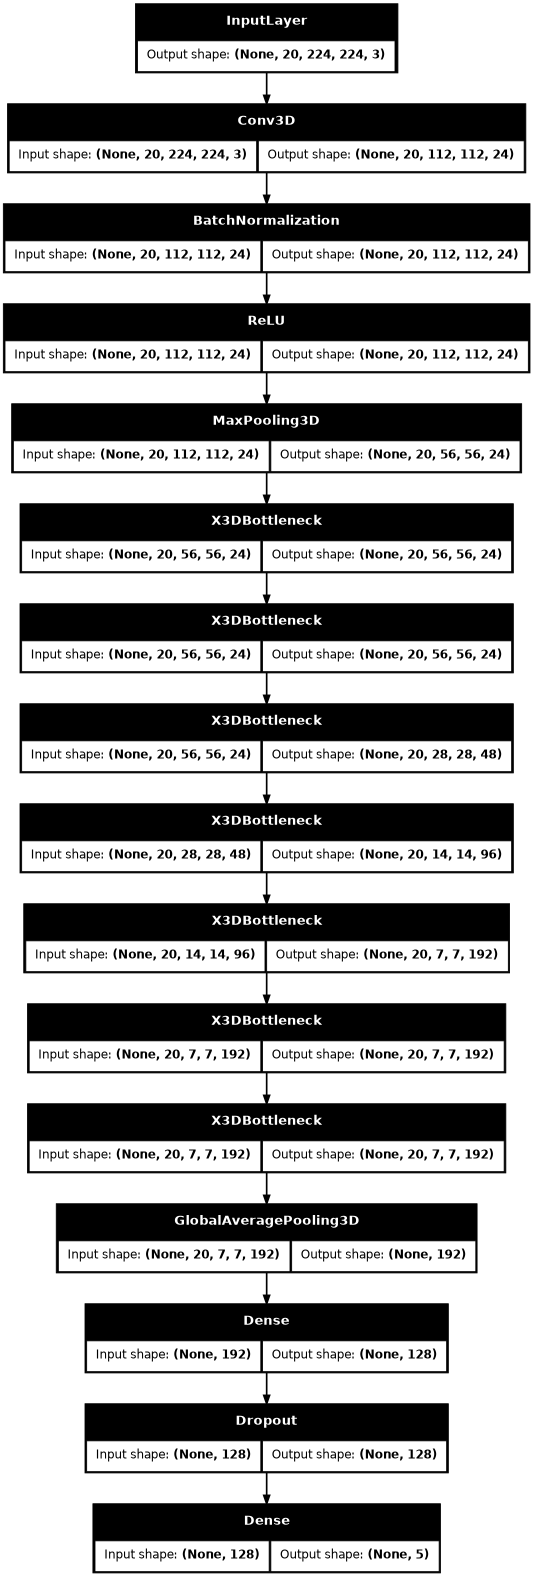

In [30]:
# Visualize the model
keras.utils.plot_model(model_1, expand_nested=True, dpi=60, show_shapes=True)

#### Train the model

In [31]:
# Create a callback that saves the model's weights while training
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_X3D.keras',       
    save_weights_only=False,           
    save_best_only=True,                
    monitor='val_loss',                 
    mode='min',                         
)

early_stopping_model = keras.callbacks.EarlyStopping(
    monitor='val_loss',        
    patience=15,                
    min_delta=1e-4,            
    restore_best_weights=True  
)

In [32]:
history_1 = model_1.fit(x = train_ds,
                    epochs = 300, # You can change this if you want, ikaw bahala
                    callbacks=[checkpoint, early_stopping_model],
                    validation_data = val_ds)

Epoch 1/300


2024-11-29 11:13:44.487581: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_21', 28 bytes spill stores, 28 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_20', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_19', 12 bytes spill stores, 12 bytes spill loads



    155/Unknown 21s 60ms/step - accuracy: 0.2567 - loss: 1.6633

/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-11-29 11:14:09.835260: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11115922884101125363


155/155 ━━━━━━━━━━━━━━━━━━━━ 40s 183ms/step - accuracy: 0.2571 - loss: 1.6622 - val_accuracy: 0.2462 - val_loss: 1.6281
Epoch 2/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3878 - loss: 1.2796

2024-11-29 11:14:36.459335: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3999199274207644657
2024-11-29 11:14:36.459373: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11115922884101125363


155/155 ━━━━━━━━━━━━━━━━━━━━ 27s 172ms/step - accuracy: 0.3877 - loss: 1.2795 - val_accuracy: 0.4769 - val_loss: 1.2197
Epoch 3/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4559 - loss: 1.1699

2024-11-29 11:15:04.003184: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3999199274207644657
2024-11-29 11:15:04.003219: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11115922884101125363


155/155 ━━━━━━━━━━━━━━━━━━━━ 28s 178ms/step - accuracy: 0.4559 - loss: 1.1701 - val_accuracy: 0.4615 - val_loss: 1.0100
Epoch 4/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - accuracy: 0.4616 - loss: 1.1220 - val_accuracy: 0.5692 - val_loss: 1.0119
Epoch 5/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 24s 155ms/step - accuracy: 0.4679 - loss: 1.1146 - val_accuracy: 0.5077 - val_loss: 1.1315
Epoch 6/300
  1/155 ━━━━━━━━━━━━━━━━━━━━ 22s 149ms/step - accuracy: 1.0000 - loss: 0.3149

2024-11-29 11:15:52.257941: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11115922884101125363


155/155 ━━━━━━━━━━━━━━━━━━━━ 26s 170ms/step - accuracy: 0.5406 - loss: 0.9863 - val_accuracy: 0.5692 - val_loss: 0.9476
Epoch 7/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.6036 - loss: 0.9364 - val_accuracy: 0.4615 - val_loss: 1.4238
Epoch 8/300
  1/155 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.5000 - loss: 0.7397

2024-11-29 11:16:38.700935: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3999199274207644657
2024-11-29 11:16:38.700991: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11115922884101125363


155/155 ━━━━━━━━━━━━━━━━━━━━ 23s 151ms/step - accuracy: 0.6075 - loss: 0.8503 - val_accuracy: 0.6000 - val_loss: 1.0498
Epoch 9/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 24s 158ms/step - accuracy: 0.6601 - loss: 0.8055 - val_accuracy: 0.4462 - val_loss: 1.8605
Epoch 10/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - accuracy: 0.6555 - loss: 0.7657 - val_accuracy: 0.5385 - val_loss: 1.1764
Epoch 11/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 24s 155ms/step - accuracy: 0.6746 - loss: 0.7263 - val_accuracy: 0.5231 - val_loss: 1.0852
Epoch 12/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.7310 - loss: 0.6559 - val_accuracy: 0.6154 - val_loss: 1.1168
Epoch 13/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 23s 151ms/step - accuracy: 0.7434 - loss: 0.6998 - val_accuracy: 0.5846 - val_loss: 1.0313
Epoch 14/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 24s 153ms/step - accuracy: 0.7935 - loss: 0.5245 - val_accuracy: 0.5846 - val_loss: 1.0788
Epoch 15/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.7870 - loss:

2024-11-29 11:21:10.601536: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3999199274207644657
2024-11-29 11:21:10.601575: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11115922884101125363


155/155 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - accuracy: 0.9127 - loss: 0.2440 - val_accuracy: 0.5538 - val_loss: 2.1842
Epoch 21/300
  1/155 ━━━━━━━━━━━━━━━━━━━━ 19s 126ms/step - accuracy: 0.0000e+00 - loss: 0.8954

2024-11-29 11:21:31.330994: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3999199274207644657
2024-11-29 11:21:31.331031: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11115922884101125363


155/155 ━━━━━━━━━━━━━━━━━━━━ 24s 154ms/step - accuracy: 0.8818 - loss: 0.2870 - val_accuracy: 0.6308 - val_loss: 1.3563


- `Remarks`: Why use more than 100 epochs you ask? Because some [Indian guy on YouTube](https://youtu.be/QmtSkq3DYko?si=V28jCOfot8MeHep6) used 500 epochs to train his Action Recognition model, therefore it is also wise to use the same training scheme. What a chad!

#### Plot the model and get the metrics

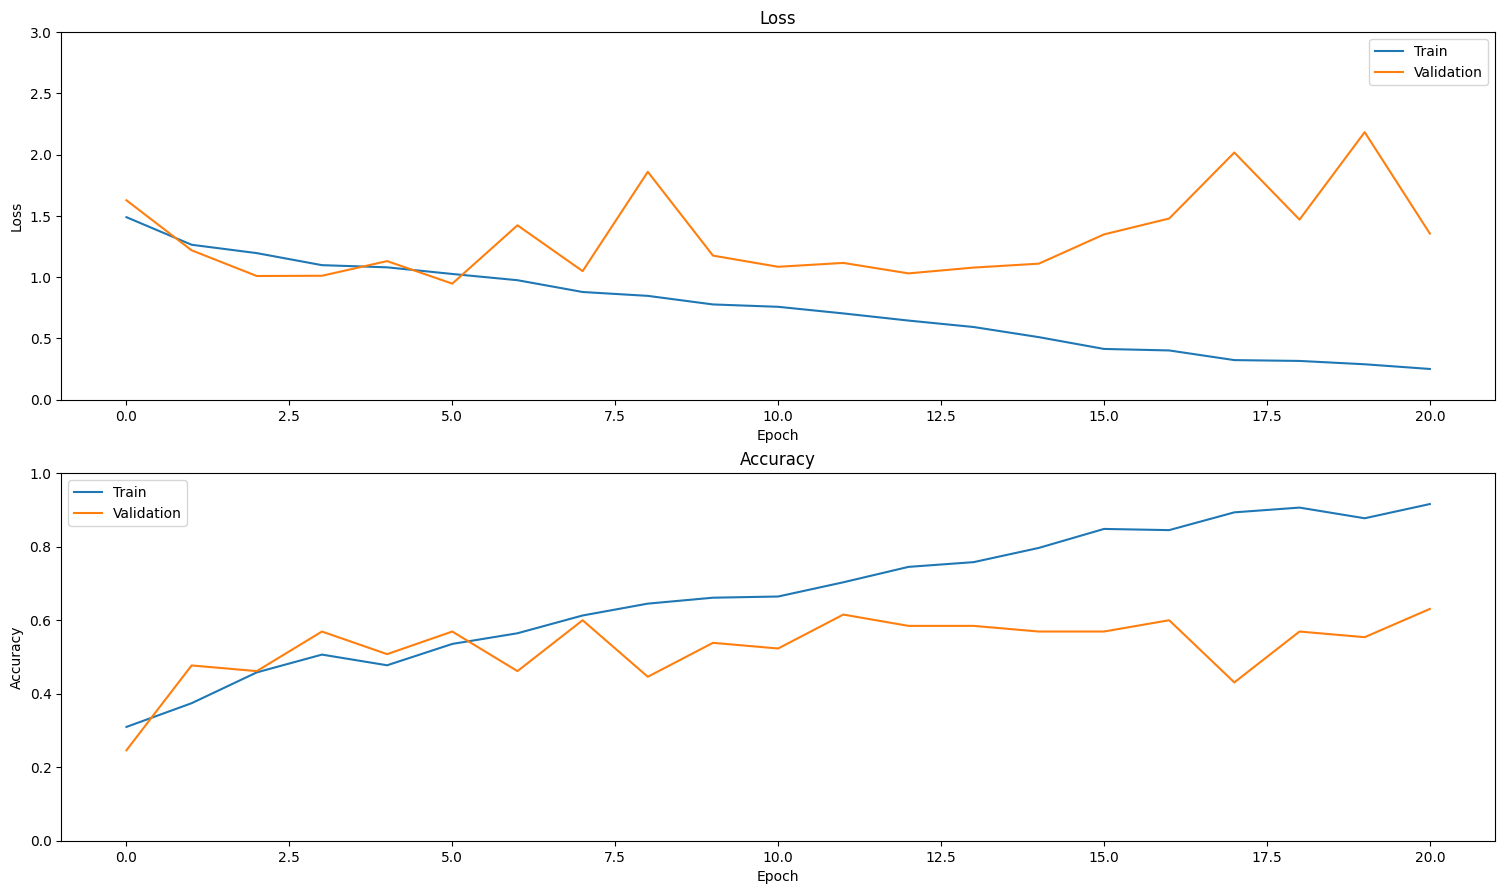

In [33]:
plot_history(history_1)

In [34]:
test_ds = configure_dataset(dataset_paths['test'], SEQUENCE_LENGTH, training=False)

# Create the training set
test_frames, test_labels = next(iter(test_ds))
print(f'Shape of validating set of frames: {test_frames.shape}')
print(f'Shape of validating labels: {test_labels.shape}')

Shape of validating set of frames: (2, 20, 224, 224, 3)
Shape of validating labels: (2,)


In [35]:
model_1.evaluate(test_ds, return_dict=True)

35/35 ━━━━━━━━━━━━━━━━━━━━ 27s 761ms/step - accuracy: 0.3989 - loss: 1.2702


{'accuracy': 0.5142857432365417, 'loss': 1.1492646932601929}

In [36]:
fg = FrameGenerator(dataset_paths['train'], SEQUENCE_LENGTH, training=True)
labels = list(fg.class_ids_for_name.keys())

155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


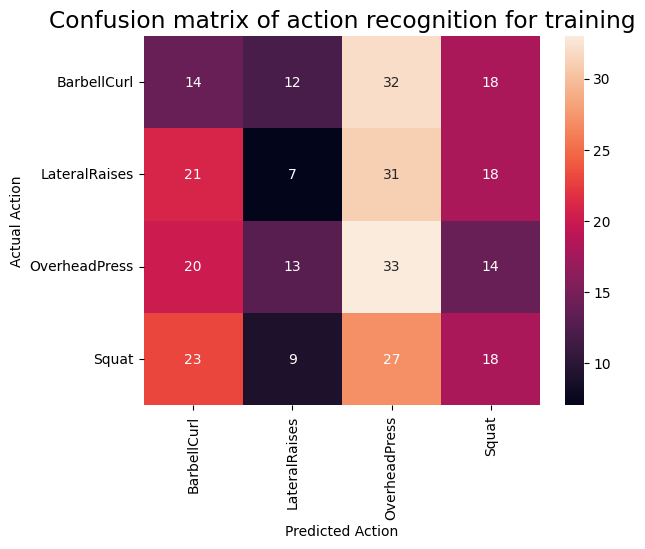

In [37]:
actual, predicted = get_actual_predicted_labels(train_ds, model_1)
plot_confusion_matrix(actual, predicted, labels, 'training')

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 603ms/step


/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


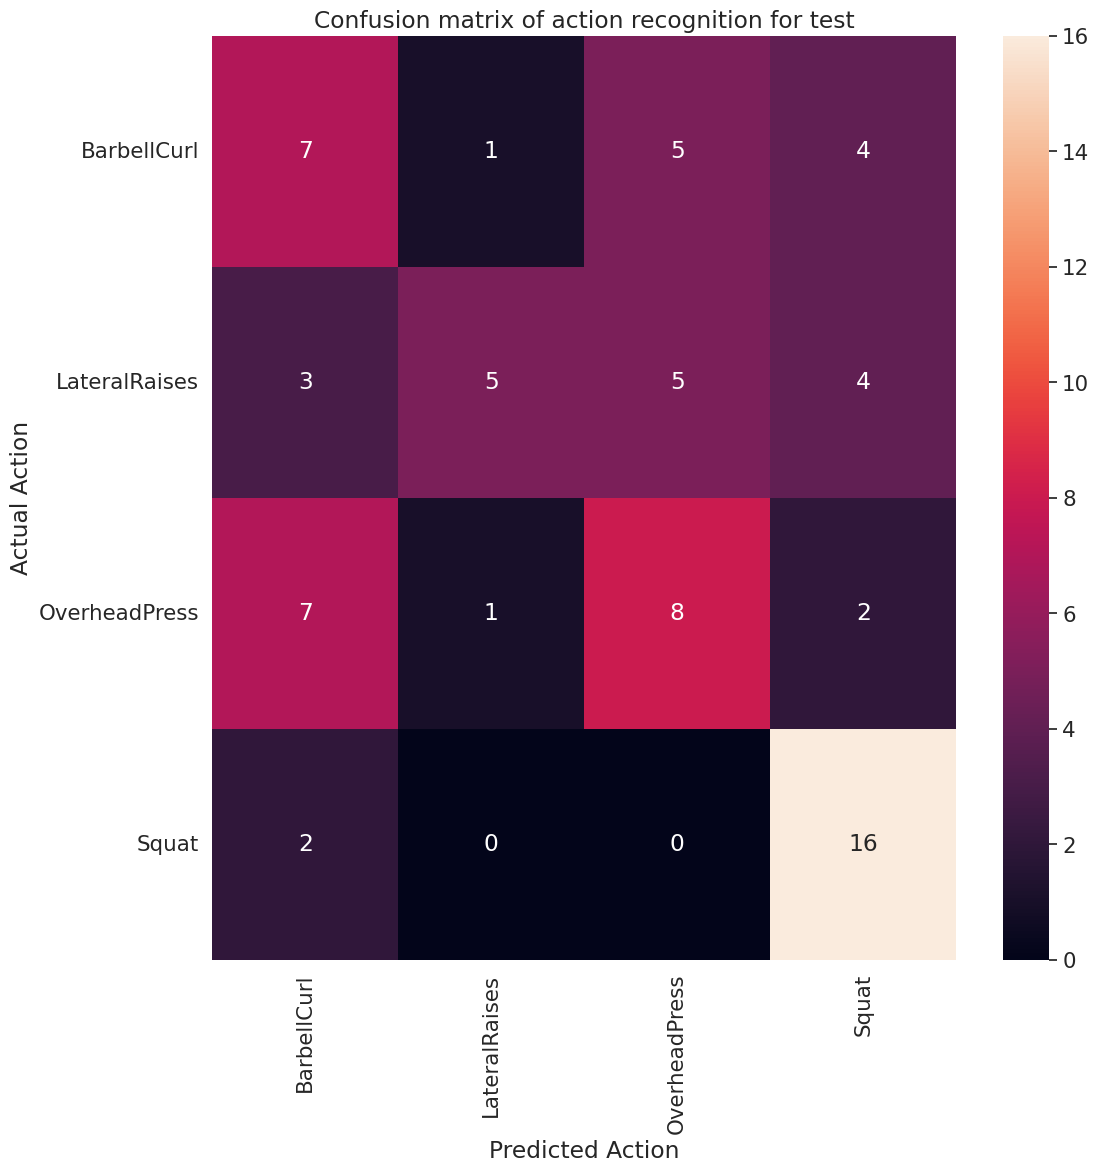

In [38]:
actual, predicted = get_actual_predicted_labels(test_ds, model_1)
plot_confusion_matrix(actual, predicted, labels, 'test')

In [39]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [40]:
precision

{'BarbellCurl': 0.3684210526315789,
 'LateralRaises': 0.7142857142857143,
 'OverheadPress': 0.4444444444444444,
 'Squat': 0.6153846153846154}

In [41]:
recall

{'BarbellCurl': 0.4117647058823529,
 'LateralRaises': 0.29411764705882354,
 'OverheadPress': 0.4444444444444444,
 'Squat': 0.8888888888888888}

#### Load Model

In [42]:
## Load model
load_model = keras.models.load_model('model_X3D.keras',
                                    custom_objects={'SEBlock': SEBlock,
                                                    'X3DBottleneck': X3DBottleneck,
                                                    })

/mnt/d/vscodeProjects/wincuda/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'x3d_bottleneck_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/mnt/d/vscodeProjects/wincuda/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'x3d_bottleneck_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/mnt/d/vscodeProjects/wincuda/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `buil

#### Evaluate the Model

In [43]:
actual, predicted = get_actual_predicted_labels(test_ds, load_model)

35/35 ━━━━━━━━━━━━━━━━━━━━ 26s 692ms/step


/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


In [44]:
f1_score = calculate_f1_score(actual, predicted, labels)
f1_score[1]

0.4949267697221459

In [45]:
### Check if correct, tama naman
"""
precision, recall = calculate_classification_metrics(actual, predicted, labels)
def f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall)

class1_f1 = f1_score(precision['BarbellCurl'], recall['BarbellCurl'])
class2_f1 = f1_score(precision['Deadlift'], recall['Deadlift'])
class3_f1 = f1_score(precision['Squat'], recall['Squat'])

macro_f1 = (class1_f1 + class2_f1 + class3_f1) / 3
print(f"Macro F1 score: {macro_f1:.4f}")
"""

'\nprecision, recall = calculate_classification_metrics(actual, predicted, labels)\ndef f1_score(precision, recall):\n    return 2 * (precision * recall) / (precision + recall)\n\nclass1_f1 = f1_score(precision[\'BarbellCurl\'], recall[\'BarbellCurl\'])\nclass2_f1 = f1_score(precision[\'Deadlift\'], recall[\'Deadlift\'])\nclass3_f1 = f1_score(precision[\'Squat\'], recall[\'Squat\'])\n\nmacro_f1 = (class1_f1 + class2_f1 + class3_f1) / 3\nprint(f"Macro F1 score: {macro_f1:.4f}")\n'

In [46]:
proba = load_model.predict(test_ds)

35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 709ms/step


In [47]:
MAP = calculate_map(actual, proba, len(labels))
MAP

0.5783140192253813

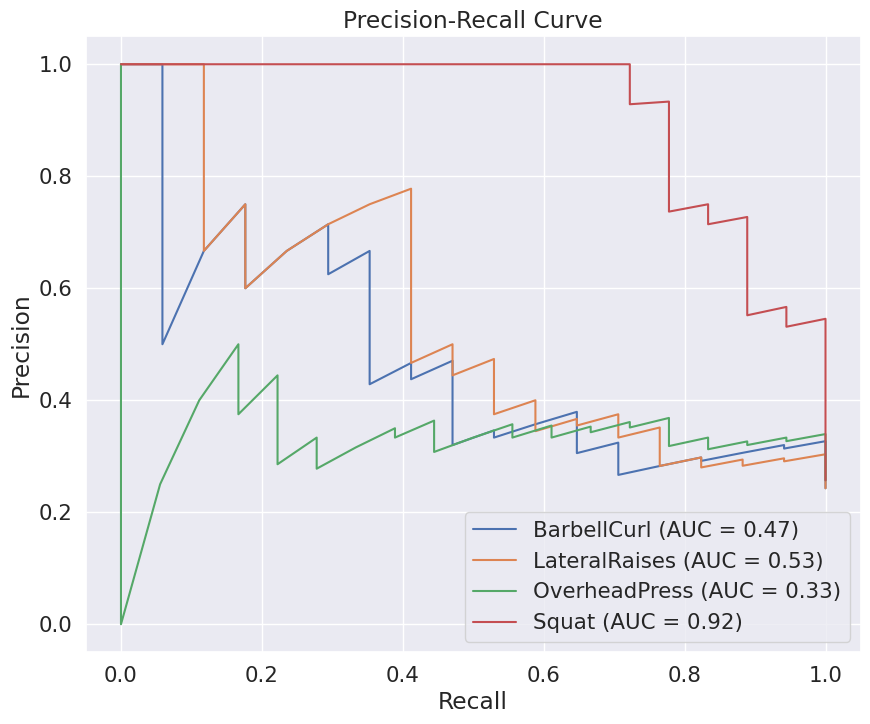

{'BarbellCurl': 0.47185955961097564,
 'LateralRaises': 0.5344281335900051,
 'OverheadPress': 0.3315258984278206,
 'Squat': 0.916261129410517}

In [48]:
plot_precision_recall_curve(actual, proba, labels)

- Ganto si curve kasi may class imbalance, shhh muna wala pa matinong dataset :)

In [49]:
import time
import psutil

def measure_latency_cpu_usage(model, test_inputs):
    process = psutil.Process()
    cpu_start = process.cpu_percent()
    start = time.time()
    predictions = model.predict(test_inputs)
    end = time.time()
    cpu_end = process.cpu_percent()
    latency = end - start
    cpu_usage = cpu_end - cpu_start
    return latency, cpu_usage

latency, cpu_usage = measure_latency_cpu_usage(load_model, test_ds)

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 607ms/step


/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


In [50]:
latency, cpu_usage

(21.160722255706787, 362.3)

#### Test the Model

In [51]:
sequence_length = SEQUENCE_LENGTH
resize_shape = (HEIGHT, WIDTH)
file_dir = 'unknown/Deadlift2.mp4'


cap = cv2.VideoCapture(file_dir)
frames = []
total_lat = []
predicted_label = ""

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame")
        break

    # Resize and convert color from BGR to RGB
    resized_frame = cv2.resize(frame, resize_shape)
    rgb_frame = resized_frame[:, :, ::-1]

    frames.append(rgb_frame)

    display_text = f"Activity: {predicted_label}"
    cv2.putText(frame, display_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    cv2.imshow('Cam', frame)

    if len(frames) == sequence_length:
        frames_array = np.array(frames) / 255.0  # Normalize to [0, 1]
        frames_array = np.expand_dims(frames_array, axis=0)  # Shape (1, 10, height, width, 3)

        prediction = load_model.predict(frames_array)
        latency, cpu_usage = measure_latency_cpu_usage(load_model, frames_array)
        total_lat.append(latency)

        predicted_index = np.argmax(prediction, axis=1)[0]
        predicted_label = sorted(LABELS)[predicted_index]
        print("Activity:", predicted_label)

        frames = []

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
print("Latency:", np.mean(total_lat))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Activity: OverheadPress
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Activity: OverheadPress
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Activity: OverheadPress
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Activity: OverheadPress
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Activity: OverheadPress
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Activity: OverheadPress
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Activity: OverheadPress
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Activity: OverheadPress
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Activity: OverheadPress
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Activity: OverheadPress
Fa